In [24]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
])

# Generate 2 seconds of dummy audio for the sake of example
samples = np.random.uniform(low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# Augment/transform/perturb the audio data
augmented_samples = augment(samples=samples, sample_rate=16000)

print(augmented_samples.shape)

(32000,)


In [16]:
from IPython.display import Audio
Audio(augmented_samples, rate=16000)

NameError: name 'augmented_samples' is not defined

In [2]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

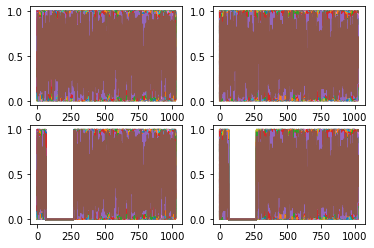

In [17]:
from audiomentations import SpecCompose, SpecChannelShuffle, SpecFrequencyMask
import numpy as np

augment = SpecCompose(
    [
        SpecChannelShuffle(p=0.5),
        SpecFrequencyMask(p=0.7),
    ]
)

# Example spectrogram with 1025 frequency bins, 256 time steps and 2 audio channels
spectrogram = np.random.random((1025, 256, 2))

figure, axes = plt.subplots(2, 2)
axes[0][0].plot(spectrogram[:,:,0])
axes[0][1].plot(spectrogram[:,:,1])
# Augment/transform/perturb the spectrogram
augmented_spectrogram = augment(spectrogram)
axes[1][0].plot(augmented_spectrogram[:,:,0])
axes[1][1].plot(augmented_spectrogram[:,:,1])
plt.show(block=False)

In [56]:
from torchaudio.transforms import Resample
import torchaudio
# resample = Resample(input_sample_rate, output_sample_rate,
#                     resampling_method = 'kaiser_window', lowpass_filter_width= 64)
# resample2 = Resample(output_sample_rate, input_sample_rate,
#                      resampling_method = 'kaiser_window', lowpass_filter_width= 64)
audio_path_raw = 'TanhDistortion_input.flac'
waveform_raw, sample_rate_raw = torchaudio.load(audio_path_raw)
sample_rate_out = 2000
sample_rate_high = 44100
# resample = Resample(sample_rate_raw, sample_rate_out,resampling_method = 'kaiser_window', lowpass_filter_width= 16)
# resample2 = Resample(sample_rate_out, sample_rate_high, lowpass_filter_width= 1)
# waveform_sample = resample2(resample(waveform_raw))
print(sample_rate_raw)

16000


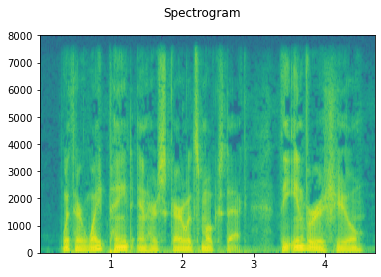

In [48]:
plot_specgram(waveform_raw, sample_rate_raw)
Audio(waveform_raw.numpy(),rate=sample_rate_raw)

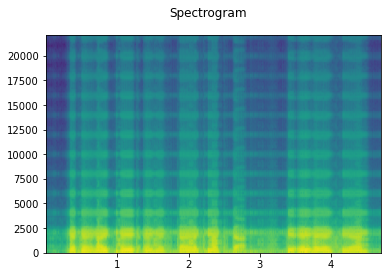

In [57]:
plot_specgram(waveform_sample, sample_rate_high)
Audio(waveform_sample.numpy(),rate=sample_rate_high)

模拟1

torch.Size([1, 75200])
torch.Size([1, 4935])


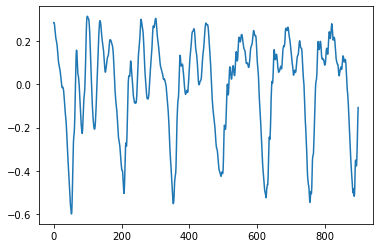

In [195]:
from torchaudio.transforms import Resample
import torchaudio
import matplotlib.pyplot as plt
import torch
from IPython.display import Audio
import numpy as np
audio_path_raw = 'TanhDistortion_input.flac'
waveform_raw, sample_rate_raw = torchaudio.load(audio_path_raw)
print(waveform_raw.shape)
sample_rate_low = 1050
sample_rate_high = 44100 # 需要整除low
resample = Resample(sample_rate_raw, sample_rate_low)
waveform_sample = resample(waveform_raw)
print(waveform_sample.shape)
plt.plot(waveform_raw.numpy()[0,12500:13400])


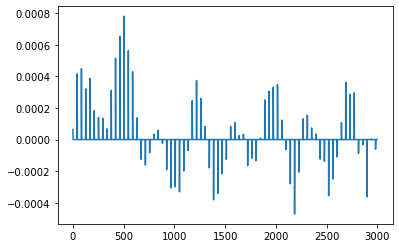

In [6]:
upsample_ratio = sample_rate_high//sample_rate_low
t = torch.zeros(1,(waveform_sample.shape[1])*upsample_ratio)
t[0,::upsample_ratio] = waveform_sample 
plt.plot(t.numpy()[0,0:3000])

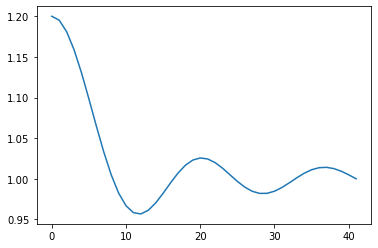

In [163]:
impulselength =300
x = np.linspace(-5, 5, impulselength)
x2= np.linspace(0, 5, impulselength)
x3= np.linspace(0, 5, upsample_ratio)
ImpulseSignal = 1-1/(1 + np.exp(-x))+ 0.4*np.sinc(x2)+np.hamming(1.5*impulselength)[-1-impulselength:-1]
ImpulseSignal = np.ones(upsample_ratio) +0.2*np.sinc(x3)
# ImpulseSignal = np.sinc(x2)
# plt.semilogy(ImpulseSignal/0.01)
ImpulseSignal = np.reshape(ImpulseSignal,(1,-1))
filepath="testaudio\impulse.wav"
torchaudio.save(filepath, torch.from_numpy(ImpulseSignal), 44100)
plt.plot(ImpulseSignal[0,:])

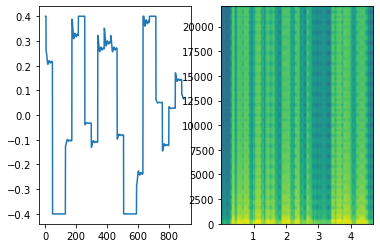

In [164]:
from audiomentations import Compose, ApplyImpulseResponse, Gain, Clip

augment = Compose([
    ApplyImpulseResponse(ir_path="testaudio", p=1.0),
    Gain(min_gain_db=9.0,max_gain_in_db=9.0,p=1.0),
    Clip(a_min=-0.4,a_max=0.4,p=1.0)
])

augmented_sound = augment(t.numpy(), sample_rate=44100)
fig,axe=plt.subplots(1,2)
axe[0].plot(augmented_sound[0,53000:53900])
axe[1].specgram(augmented_sound[0,:],Fs=44100)
outfile = "outputaudio/aa.wav"
torchaudio.save(outfile, torch.from_numpy(augmented_sound), 44100)
Audio(augmented_sound,rate=44100)



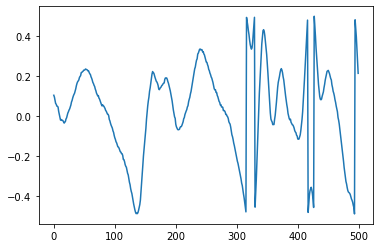

In [221]:
from audiomentations import Compose, Gain, Clip, AddGaussianNoise
limit = 0.5
is_count = False
wave = waveform_raw.numpy()
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001,max_amplitude=0.003,p=1.0),
    Gain(min_gain_db=7.0,max_gain_in_db=7.0,p=1.0),
    Clip(a_min=-1.0,a_max=1.0,p=1.0),
])
wave = augment(wave, sample_rate=16000)
wavecopy =wave.copy()
for point in range(0,wave.shape[1]):
    if abs(wave[0,point]) >= limit and is_count == False:
        is_count =True
        temppoint = point
        sign = int(np.sign(wave[0,point]))
    elif abs(wave[0,point]) <= limit and is_count == True:
        winlen = point-temppoint
        wavecopy[0,temppoint:point] -= sign*np.ones(winlen)
        is_count =False
outfile = "outputaudio/bb.wav"
torchaudio.save(outfile, torch.from_numpy(wavecopy), 16000)
plt.plot(wavecopy[0,11000:11500])
Audio(wavecopy,rate=16000)


